In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math
import params

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors

from scipy.optimize import minimize
from scipy.optimize import curve_fit
from math import floor,log10

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.01

Question to be debiased: t01_smooth_or_features


In [4]:
data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

low_z_lim = 0.03
data = data[data['REDSHIFT_1'] > low_z_lim]

# For this code, go through each of the answers separately
answers = questions[question]['answers']
answer = answers[0]
raw_column = data[question + '_' + answer + '_weighted_fraction']
fv_nonzero = raw_column > 0 # Select only the non-zero data to add to the 'signal' for each bin.

Loaded galaxy data...
Loaded questions...
Loaded functions...


Bin-accretion...
1629  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  39004
Fractional S/N scatter (%): 8.51802453966
25 voronoi bins
82.28 redshift bins per voronoi bin


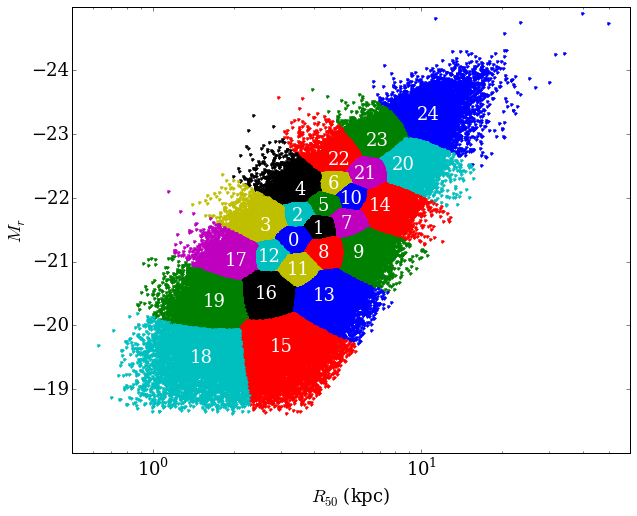

In [5]:
import binning

vbins,zbins,zbins_coarse,vbins_table = binning.bin_data(data,question,answer)

In [36]:
def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()


def f_logistic(x,k,c):
    alpha = np.exp(-k*x + c)
    return 1/(1+alpha)

    
def f_exp_pow(x,k,c):
    return np.exp((-k)*(-x)**c)


def fit_vbin_function(data, vbins, zbins, fit_setup,
                      question,answer,kc_fit_results=None,
                      plot=bins_to_plot,min_log_fv=min_log_fv,
                      even_sampling=True):
    
    start_time = time.time()

    redshift = data['REDSHIFT_1']
    fv = question + '_' + answer +'_weighted_fraction'
    
    if kc_fit_results is not None:
        kcfunc, kparams, cparams, lparams,kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    bounds = fit_setup['bounds']
    p0 = fit_setup['p0']
    func = fit_setup['f']
    
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        zbins_v = zbins[vselect]

        z_bins_unique = np.unique(zbins_v)

        for z in z_bins_unique:
            data_z = data_v[zbins_v == z]
            n = len(data_z)
            
            D = data_z[[fv]]
            D.sort(fv)
            D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
            D['log10fv'] = np.log10(D[fv])
            if even_sampling:
                D_fit_log10fv = np.log10(np.linspace(10**(min_log_fv), 1, 1000))
                D = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)]
                indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
                D_fit = D[indices.clip(0, len(D)-1)]
            else:
                D = D[D['log10fv'] > min_log_fv]

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
            res = minimize(chisq_fun, p0,
                           args=(func,
                                 D['log10fv'].astype(np.float64),
                                 D['cumfrac'].astype(np.float64)),
                           bounds=bounds, method='SLSQP')
            p = res.x
            chi2nu = res.fun / (n - len(p))
                
            means = [data_z['PETROMAG_MR'].mean(),
                     np.log10(data_z['PETROR50_R_KPC']).mean(),
                     data_z['REDSHIFT_1'].mean()]

            if len(p) < 2:
                p = np.array([p[0], 10])

            param_data.append([v,z] + means + p[:2].tolist() + # Maybe change output table here
                              [chi2nu])
            
    fit_vbin_results = Table(rows=param_data,
                             names=('vbin','zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c', 'chi2nu'))
    
    print('All bins fitted! {}s in total'.format(time.time()-start_time))
    
    return fit_vbin_results

In [47]:
fit_setup = {}
fit_setup['f'] = f_exp_pow
fit_setup['p0'] = [1,1]
fit_setup['bounds'] = ((10**(-5),10**(5)),(10**(-5),10**5))

fit_vbin_results = fit_vbin_function(data, vbins, zbins_coarse, fit_setup,question,answer)

kmin,kmax = [np.min(fit_vbin_results['k']),np.max((fit_vbin_results['k']))]
cmin,cmax = [np.min(fit_vbin_results['c']),np.max((fit_vbin_results['c']))]

All bins fitted! 22.395432472229004s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log10


All bins fitted! 14.76280951499939s in total
All bins fitted! 16.437567234039307s in total
All bins fitted! 21.345727682113647s in total
All bins fitted! 23.10929226875305s in total
All bins fitted! 23.388713121414185s in total
All bins fitted! 22.96247410774231s in total
All bins fitted! 23.189372777938843s in total
All bins fitted! 22.669201374053955s in total
All bins fitted! 22.594654083251953s in total
All bins fitted! 22.54214906692505s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log10


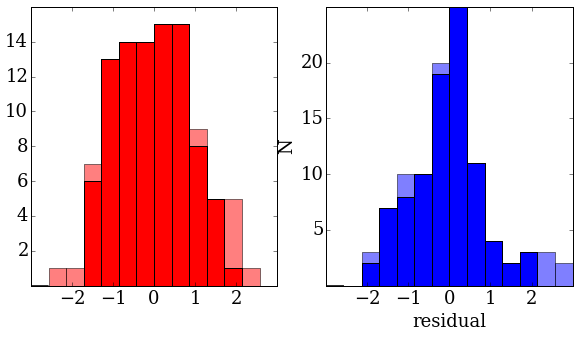

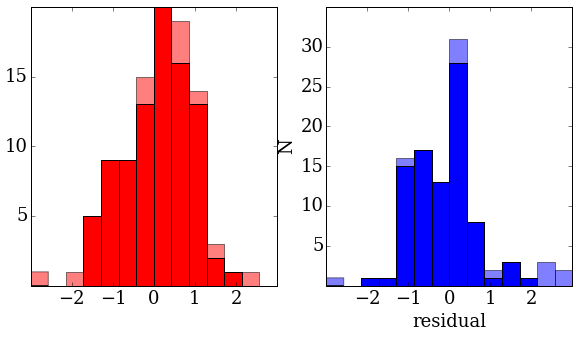

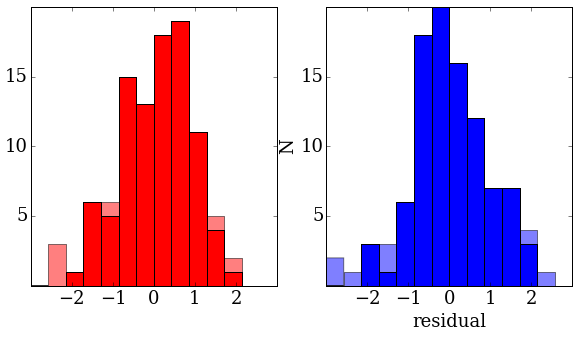

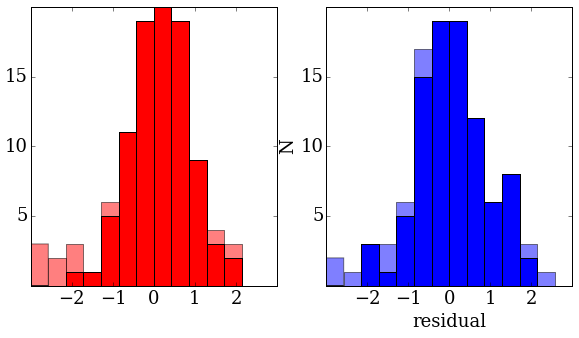

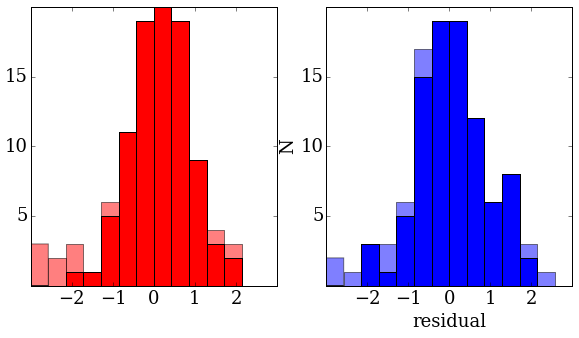

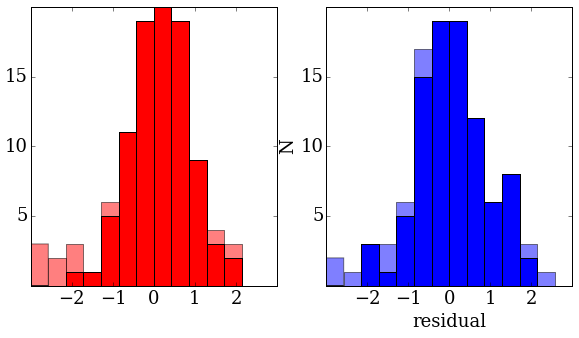

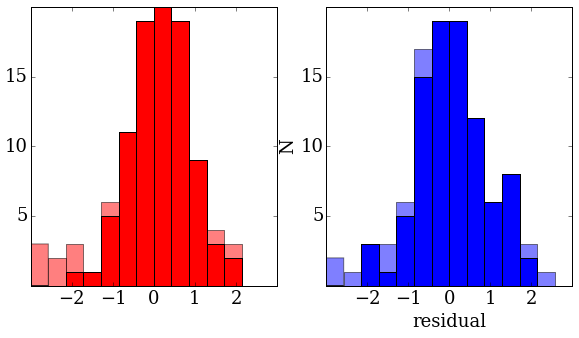

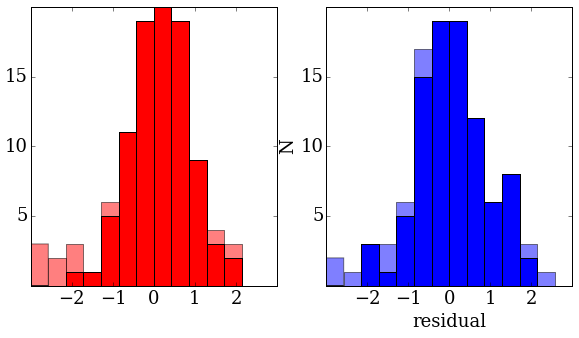

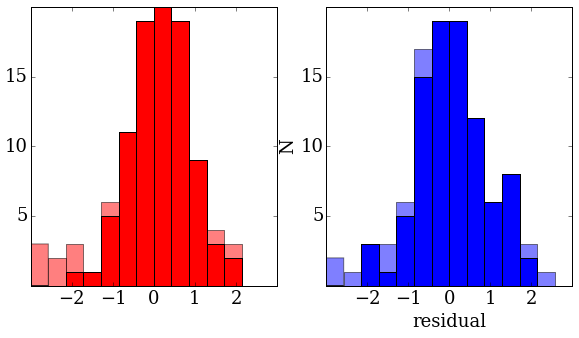

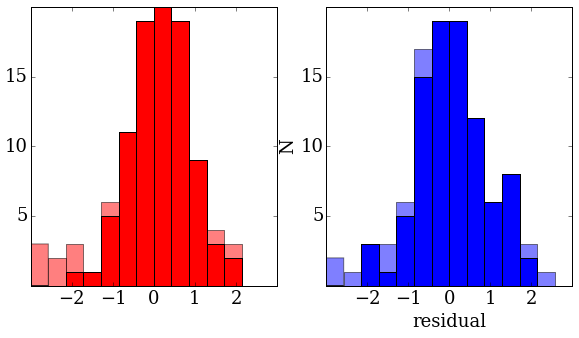

In [87]:
k_values = 10**(np.logspace(math.log10(kmin),math.log10(kmax),10))
c_values = 10**(np.logspace(math.log10(cmin),math.log10(cmax),10))

nwalkers = 100
ndim = 10

initial_theta = np.zeros((nwalkers,ndim))

for r,bounds in enumerate(np.logspace(kmin,kmax,10)):
    
    upper_k = k_values[r]
    upper_c = c_values[r]
    
    fit_setup['bounds'] = ((10**(-5),upper_k),(10**(-5),10**5))
    
    fit_vbin_results = fit_vbin_function(data, vbins, zbins_coarse, fit_setup,question,answer)
    
    kparams, cparams, dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, kcfunc,clip=2)
    
    initial_theta[r,:8] = kparams[0].tolist() + cparams[0].tolist()

In [91]:
initial_theta_2 = initial_theta.copy()
# make a copy
for m in range(9):
    
    initial_theta_2[10*m:10*m+10] = initial_theta[0:10]

In [92]:
from scipy.optimize import curve_fit


def kcfunc(x, A0, AM, AR, Az):#,nz):
    # linear combination of (magnitude, size, redshift) + an offset
    #logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    return logr


def normalise(x):
    return (x - x.mean())/x.std()


def fit_mrz(d, f=kcfunc,clip=None):
    # Fit a linear function of M, R and z to k and c
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []

    # Set limits of the functions here.
    kmin = d['k'].min() 
    kmax = d['k'].max() 
    cmin = d['c'].min()
    cmax = d['c'].max()

    # Loop over GZ morphologies
    x = np.array([d[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
    k = d['k'].astype(np.float64)
    c = d['c'].astype(np.float64)

    kp, kc = curve_fit(f, x, k, maxfev=100000)
    cp, cc = curve_fit(f, x, c, maxfev=100000)
        
    kres = f(x, *kp) - k
    knormres = normalise(kres)

    cres = f(x, *cp) - c
    cnormres = normalise(cres)
    
    bins = np.linspace(-3,3,15)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.hist(knormres,color='r',alpha=0.5,bins=bins)
    plt.subplot(1,3,2)
    plt.hist(cnormres,color='b',alpha=0.5,bins=bins)
    plt.xlabel('residual')
    plt.ylabel('N')
        
    if clip != None:
        
        clipped = ((np.absolute(knormres) < clip) & (np.absolute(cnormres) < clip))
                    #& (np.absolute(lnormres) < clip))# 'clip' sigma clipping
        kp, kc = curve_fit(f, ((x.T)[clipped]).T, k[clipped], maxfev=100000)
        cp, cc = curve_fit(f, ((x.T)[clipped]).T, c[clipped], maxfev=100000)

        plt.subplot(1,3,1)
        plt.hist(knormres[clipped],color='r',bins=bins)
        plt.subplot(1,3,2)
        plt.hist(cnormres[clipped],color='b',bins=bins)
        plt.xlabel('residual')
        plt.ylabel('N')
        
    dout['kf'] = f(x, *kp)
    dout['cf'] = f(x, *cp)
        
    kparams.append(kp)
    cparams.append(cp)

    return kparams, cparams, dout, kmin, kmax, cmin, cmax

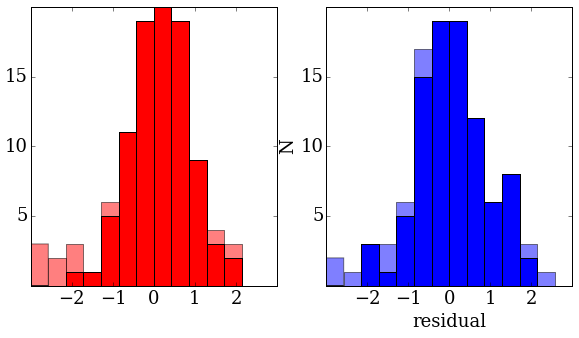

In [93]:
kparams,cparams,dout,kmin,kmax,cmin,cmax = fit_mrz(fit_vbin_results, kcfunc,clip=2)

In [94]:
def total_bins(vbins,zbins):
    num_zv = 0
    for v in np.unique(vbins):
        zbins_v = zbins[vbins == v]
        num_zv = num_zv + len(np.unique(zbins_v))
    return num_zv

In [95]:
def cf_bins(data,vbins,zbins,question=question,answer=answer,
            min_log_fv=min_log_fv,max_log_fv=max_log_fv):
    
    fraction = question + '_' + answer + '_weighted_fraction'
    count = question + '_' + answer + '_count'
    
    N_b = total_bins(vbins,zbins)
    cf_values = np.zeros((N_b,100))
    bin_parameters = np.zeros((N_b,5))
    i = 0 # Row index
    
    for v in np.unique(vbins):
        zbins_v = zbins[vbins == v]
        
        for z in np.unique(zbins_v):
            
            vz_data = data[(vbins == v) & (zbins == z)]
            p_values = np.sort(vz_data[fraction])
            fv_nonzero = p_values != 0
            n = len(p_values)
            cumfrac = np.linspace(0,1,n)
            p_values = np.log10(p_values)
            
            Mr = np.mean(vz_data['PETROMAG_MR'])
            R50 = np.mean(vz_data['PETROR50_R_KPC'])
            redshift = np.mean(vz_data['REDSHIFT_1'])
        
            D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
            D_fit_log10fv = np.log10(np.linspace(10**(min_log_fv), 1, 100))
            D = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)]
            indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
            D_fit = D[indices.clip(0, len(D)-1)]
            
            cf_values[i] = D_fit['cumfrac']
            bin_parameters[i] = [v,z,Mr,R50,redshift]
            i = i + 1
    
    fv_values = np.log10(np.linspace(10**(min_log_fv), 1, 100))
    bin_parameters = Table(bin_parameters,names=('vbin','zbin','Mr','R50','z'))
    
    return cf_values,bin_parameters,fv_values

In [96]:
#def f_logistic(x,k,c):
    # Function to fit the data bin output from the raw plot function
    #L = l*(1 + np.exp(c))
    #r = 1 / (1.0 + np.exp(-k * x + c))
    #return r

def f(x, k, c):
    # Function to fit the data bin output from the raw plot function
    r = np.exp(-k * (-x) ** c)
    return r


def kcfunc_all_bins(bin_parameters,k0,kR,kM,kz
                                  ,c0,cR,cM,cz):
    
    N_b = len(bin_parameters)
    k = np.zeros(N_b)
    c = np.zeros(N_b)
    
    for i in range(N_b):
        M_r = bin_parameters['Mr'][i]
        R50 = bin_parameters['R50'][i]
        z = bin_parameters['z'][i]

        k[i] = k0 + kM*(10**(M_r)) + kR*R50 + kz*z
        c[i] = c0 + cM**(10**(M_r)) + cR*R50 + cz*z
    
    return k,c

In [99]:
#vbins,zbins,vbins_table = bin_data(data,plot=False)
fv_values = np.log10(np.linspace(10**(min_log_fv), 1, 100))
cf_array,bin_parameters,fv_values = cf_bins(data,vbins,zbins)
e = np.ones((len(cf_array),100))*(0.001)

# cf_array = 100*N_bins
# bin_parameters = N_bins (w Mr,R50,z data)
# fv_values = 100 values for each of the bins

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


In [150]:
initial_theta_3 = initial_theta_2[:20]
print(initial_theta_3.shape)

(20, 10)


In [151]:
def model(bin_parameters,x,func,theta):
    
    N_b = len(bin_parameters)
    y_out = np.zeros((N_b,100))
    
    k0,kM,kR,kz,c0,cM,cR,cz,scatter,prob_outlier = theta
    
    for i in range(N_b):
        M_r = bin_parameters['Mr'][i]
        R50 = bin_parameters['R50'][i]
        z = bin_parameters['z'][i]

        k = k0 + kM*(10**(M_r)) + kR*R50 + kz*z
        c = c0 + cM**(10**(M_r)) + cR*R50 + cz*z
        y_out[i,:] = func(x,k,c)
    
    return y_out


def log_prior(theta):
    
    k0,kM,kR,kz,c0,cM,cR,cz,scatter,prob_outlier = theta
    # scatter must be greater than zero
    if scatter <= 0:
        return -np.inf
    # prob_outlier must be between zero and one
    if prob_outlier < 0 or prob_outlier > 1:
        return -np.inf
    
    return -1.5 * np.log(1 + kz ** 2) - np.log(scatter)

# scatter of outlier points, just needs to be much larger than normal scatter
scatter_outliers = 50.0

def log_likelihood(theta, x, y, e, scatter_outliers=scatter_outliers):
    k0,kM,kR,kz,c0,cM,cR,cz,scatter,prob_outlier = theta
    # square residuals
    y_model = model(bin_parameters,x,f,theta)
    
    # This is the 'chi' part I think:
    dy2 = (y - y_model)**2
    dy2[np.isnan(dy2)] = 0
    # avoid NaNs in logarithm
    prob_outlier = np.clip(prob_outlier, 1e-99, 1-1e-99)
    # compute effective variances by combining errors and intrinsic scatter
    eff_var = scatter**2 + e**2
    eff_var_outliers = scatter_outliers**2 + e**2
    # logL for good (normal) and bad (outlier) distributions
    logL_good = (np.log(1 - prob_outlier)
                 - 0.5 * np.log(2 * np.pi * eff_var)
                 - 0.5 * dy2 / eff_var)
    logL_bad = (np.log(prob_outlier)
                - 0.5 * np.log(2 * np.pi * eff_var_outliers)
                - 0.5 * dy2 / eff_var_outliers)    
    # using np.logaddexp helps maintain numerical precision
    return np.sum(np.logaddexp(logL_good, logL_bad))


def logl(theta):
    # PT sampler needs us to use global variables
    return log_likelihood(theta, x, y, e, scatter_outliers)


def log_posterior(theta, x, y, e, scatter_outliers=scatter_outliers):
    ll = log_likelihood(theta, x, y, e, scatter_outliers) + log_prior(theta)
    #if np.isfinite(ll) == True:
        #print(ll)
    return ll

In [152]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[fv_values, cf_array, e], threads=1)

nburn = 50
nwalkers = 20
nsamp = 50
par = ('k0','kM','kR','kz','c0','cM','cR','cz','scatter','prob_outlier')

In [153]:
r = sampler.run_mcmc(initial_theta_3, nburn+nsamp)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in square
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:51: RuntimeWarning: overflow encountered in true_divide
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in logaddexp
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in power


In [158]:
def flatten_without_burn(sampler, nburn):
    c = sampler.chain
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))


def weight_without_burn(sampler, nburn):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


def get_samples(sampler, nburn, minweight=None):
    sample = flatten_without_burn(sampler, nburn)
    if minweight is not None:
        weight = weight_without_burn(sampler, nburn)
        sample = sample[weight > minweight]
    return sample


def minmaxpad(x, p=0.05):
    xmin = x.min()
    xmax = x.max()
    xrange = xmax - xmin
    xmin = xmin - p*xrange
    xmax = xmax + p*xrange
    return xmin, xmax


def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ow')

    xmin, xmax = minmaxpad(x)
    dx = (xmax-xmin)/100.0
    xfit = np.linspace(xmin, xmax, 100)
    yfit = model(xfit[...,np.newaxis], trace.T)
    mu = yfit.mean(-1)
    sig = yfit.std(-1)
    
    ax.fill_between(xfit, mu - 2*sig, mu + 2*sig, color='lightgray')
    ax.fill_between(xfit, mu - sig, mu + sig, color='darkgray')
    ax.plot(xfit, mu, '-k')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([xmin, xmax])

    
def round_sig(x, sig=1):
    #d = sig-int(floor(log10(x)))-1
    #d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None):
    mean = samples.mean(0)
    sigma = samples.std(0)
    for i, p in enumerate(par):
        #err, dp = round_sig(sigma[i], 1)
        err = sigma[i]
        #val = round(mean[i], dp)
        val = mean[i]
        #dp = str(dp)
        #dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        #outstr = ('{:16s} = {:8.'+dp+' ± {:<8.'+dp).format(p, val, err)
        outstr = ('{} = {} ± {}').format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr)
        
    return mean

In [159]:
sample = get_samples(sampler,nburn)
summary(sample)

k0 = 37.481096516178454 ± 14.623428055700696
kM = 1.0 ± 0.0
kR = -157.9792122926725 ± 71.43486766489261
kz = 1015.0910937482536 ± 469.46660979114375
c0 = 1.453475753367864 ± 0.2828822616875364
cM = 1.0 ± 0.0
cR = -1.123002452107614 ± 0.964096196255157
cz = 6.341102210725212 ± 5.535503895114689
scatter = 0.0 ± 0.0
prob_outlier = 0.0 ± 0.0


array([  3.74810965e+01,   1.00000000e+00,  -1.57979212e+02,
         1.01509109e+03,   1.45347575e+00,   1.00000000e+00,
        -1.12300245e+00,   6.34110221e+00,   0.00000000e+00,
         0.00000000e+00])